<a href="https://colab.research.google.com/github/dauparas/tensorflow_examples/blob/master/vqvae_clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VQ-VAE for clustering data

Based on 

https://arxiv.org/abs/1711.00937  
https://arxiv.org/abs/1906.00446

https://github.com/deepmind/sonnet/blob/master/sonnet/examples/vqvae_example.ipynb



In [0]:
from __future__ import print_function

import os
import subprocess
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import sonnet as snt
import tensorflow as tf
import tarfile

from six.moves import cPickle
from six.moves import urllib
from six.moves import xrange

# Create some data

In [0]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=5000, centers=7, n_features=50,random_state=0)

# Define Encoder & Decoder


In [0]:
class Encoder(snt.AbstractModule):
  def __init__(self, name='encoder'):
    super(Encoder, self).__init__(name=name)
    
  def _build(self, x):
    h = snt.Linear(32)(x)
    h = tf.nn.relu(h)
    h = snt.Linear(16)(h)
    h = tf.nn.relu(h)
    h = snt.Linear(10)(h)
    return h

class Decoder(snt.AbstractModule):
  def __init__(self, output_dim, name='decoder'):
    super(Decoder, self).__init__(name=name)
    self.output_dim = output_dim
  
  def _build(self, x):
    h = snt.Linear(16)(x)
    h = tf.nn.relu(h)
    h = snt.Linear(32)(h)
    h = tf.nn.relu(h)
    h = snt.Linear(self.output_dim)(h)
    return h

# Build Graph and train

In [160]:
tf.reset_default_graph()

# Set hyper-parameters.
batch_size = 64

num_training_updates = 5000
embedding_dim = 10
# The higher this value, the higher the capacity in the information bottleneck.
num_embeddings = 20

# commitment_cost should be set appropriately. It's often useful to try a couple
# of values. It mostly depends on the scale of the reconstruction cost
# (log p(x|z)). So if the reconstruction cost is 100x higher, the
# commitment_cost should also be multiplied with the same amount.
commitment_cost = 0.25

# Use EMA updates for the codebook (instead of the Adam optimizer).
# This typically converges faster, and makes the model less dependent on choice
# of the optimizer. In the VQ-VAE paper EMA updates were not used (but was
# developed afterwards). See Appendix of the paper for more details.
vq_use_ema = True

# This is only used for EMA updates.
decay = 0.99

learning_rate = 3e-4

# Data Loading.
train_dataset_iterator = (
    tf.data.Dataset.from_tensor_slices(X)
    .shuffle(10000)
    .repeat(-1)  # repeat indefinitely
    .batch(batch_size)).make_one_shot_iterator()
train_dataset_batch = train_dataset_iterator.get_next()

def get_samples(sess, subset='train'):
    return sess.run(train_dataset_batch)

# Build modules.
encoder = Encoder()
decoder = Decoder(X.shape[1])

if vq_use_ema:
  vq_vae = snt.nets.VectorQuantizerEMA(
      embedding_dim=embedding_dim,
      num_embeddings=num_embeddings,
      commitment_cost=commitment_cost,
      decay=decay)
else:
  vq_vae = snt.nets.VectorQuantizer(
      embedding_dim=embedding_dim,
      num_embeddings=num_embeddings,
      commitment_cost=commitment_cost)

# Process inputs with conv stack, finishing with 1x1 to get to correct size.
x = tf.placeholder(tf.float32, shape=(None, X.shape[1]))
z = encoder(x)

# For training
vq_output_train = vq_vae(z, is_training=True)
x_recon = decoder(vq_output_train["quantize"])
recon_error = tf.reduce_mean((x_recon - x)**2) / data_variance  # Normalized MSE
loss = recon_error + vq_output_train["loss"]

# For evaluation, make sure is_training=False!
vq_output_eval = vq_vae(z, is_training=False)
x_recon_eval = decoder(vq_output_eval["quantize"])

# The following is a useful value to track during training.
# It indicates how many codes are 'active' on average.
perplexity = vq_output_train["perplexity"] 

# Create optimizer and TF session.
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss)
sess = tf.train.SingularMonitoredSession()

# Train.
train_res_recon_error = []
train_res_perplexity = []
for i in xrange(num_training_updates):
  feed_dict = {x: get_samples(sess)}
  results = sess.run([train_op, recon_error, perplexity],
                     feed_dict=feed_dict)
  train_res_recon_error.append(results[1])
  train_res_perplexity.append(results[2])
  
  if (i+1) % 100 == 0:
    print('%d iterations' % (i+1))
    print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
    print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
    print()


100 iterations
recon_error: 519.821
perplexity: 5.861

200 iterations
recon_error: 406.175
perplexity: 5.584

300 iterations
recon_error: 294.004
perplexity: 5.608

400 iterations
recon_error: 190.446
perplexity: 5.565

500 iterations
recon_error: 109.414
perplexity: 5.514

600 iterations
recon_error: 84.999
perplexity: 5.525

700 iterations
recon_error: 72.293
perplexity: 6.234

800 iterations
recon_error: 41.347
perplexity: 6.668

900 iterations
recon_error: 21.759
perplexity: 6.694

1000 iterations
recon_error: 16.664
perplexity: 6.695

1100 iterations
recon_error: 15.882
perplexity: 6.664

1200 iterations
recon_error: 15.745
perplexity: 6.693

1300 iterations
recon_error: 15.818
perplexity: 6.681

1400 iterations
recon_error: 15.773
perplexity: 6.657

1500 iterations
recon_error: 15.789
perplexity: 6.698

1600 iterations
recon_error: 15.813
perplexity: 6.670

1700 iterations
recon_error: 15.787
perplexity: 6.690

1800 iterations
recon_error: 15.762
perplexity: 6.679

1900 iteration

# Plot loss

Text(0.5, 1.0, 'Average codebook usage (perplexity).')

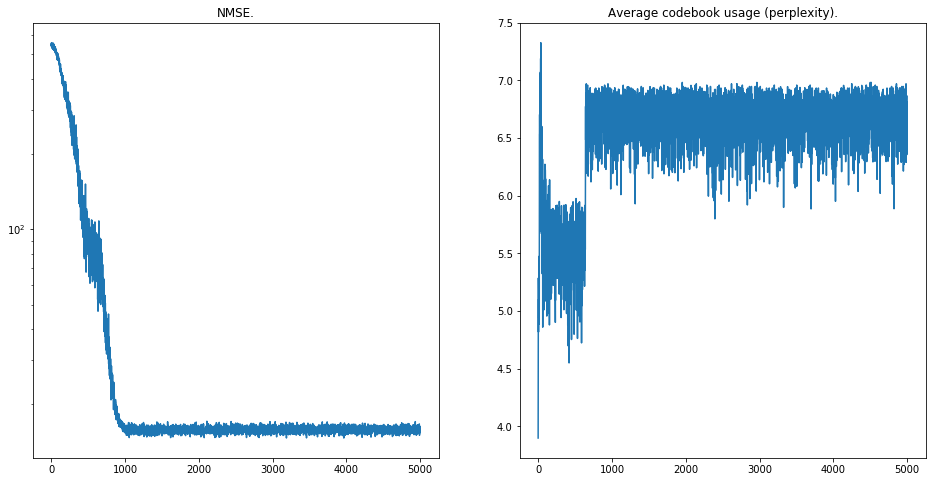

In [161]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error)
ax.set_yscale('log')
ax.set_title('NMSE.')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity)
ax.set_title('Average codebook usage (perplexity).')


# View latent space

In [0]:
# Latent space
z_, vq_output_eval_  = sess.run([z, vq_output_eval], feed_dict={x: X})

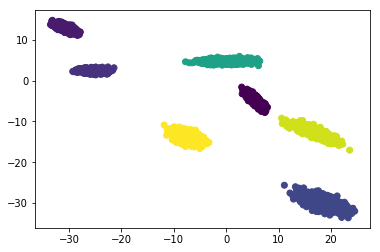

In [163]:
plt.scatter(z_[:,0], z_[:,1], c=vq_output_eval_['encoding_indices'])

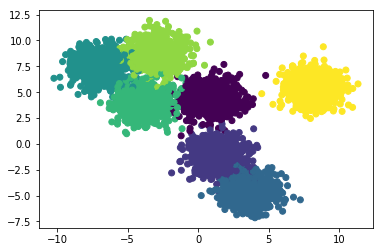

In [164]:
plt.scatter(X[:,0], X[:,1], c=y)

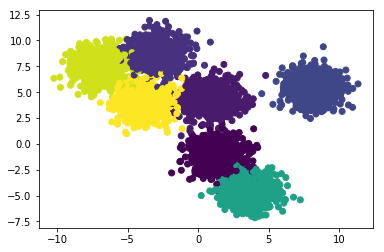

In [165]:
plt.scatter(X[:,0], X[:,1], c=vq_output_eval_['encoding_indices'])